In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/MyDrive/Paper Xu ly anh y khoa/"

/content/drive/MyDrive/Paper Xu ly anh y khoa


### Pre-processing: Count images and remove two error images from training set

Đếm số lượng hình ảnh

In [ ]:
import os

def count_images(folder_path):
    num_files = len([file_name for file_name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file_name))])
    return num_files

In [ ]:
normal_folder = "data/train/normal"
positive_folder = "data/train/positive"

effusion_folder = "data_positive/train_positive/EFFUSION"
mass_folder = "data_positive/train_positive/MASS"
pneumonia_folder = "data_positive/train_positive/PNEUMONIA"
tuberculosis_folder = "data_positive/train_positive/TUBERCULOSIS"

In [ ]:
print(f"normal: {count_images(normal_folder)}")
print(f"positive: {count_images(positive_folder)}")
print(f"\neffusion: {count_images(effusion_folder)}")
print(f"mass: {count_images(mass_folder)}")
print(f"pneumonia: {count_images(pneumonia_folder)}")
print(f"tuberculosis: {count_images(tuberculosis_folder)}")

normal: 7089
positive: 10282

effusion: 2898
mass: 1539
pneumonia: 3076
tuberculosis: 2773


Tìm ảnh bị lỗi và xóa khỏi bộ dữ liệu

In [ ]:
from PIL import Image
import os

def verify_images(dataset_path):
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                image = Image.open(file_path)
                image.verify()  # Verifies if the file is a valid image
            except (IOError, SyntaxError) as e:
                print(f"Error opening file: {file_path}")
                print(f"Error message: {str(e)}")
            except Exception as e:
                print(f"Unknown error occurred for file: {file_path}")
                print(f"Error message: {str(e)}")

# Replace 'train_set_path' and 'val_set_path' with the actual paths to your training and validation datasets
train_normal_path = 'data/train/normal'
train_positive_path = 'data/train/positive'
val_normal_path = 'data/val/normal'
val_positive_path = 'data/val/positive'

# Verify training dataset images
print("Verifying training normal dataset images...")
verify_images(train_normal_path)

print("Verifying training positive dataset images...")
verify_images(train_positive_path)

# Verify validation dataset images
print("Verifying validation normal dataset images...")
verify_images(val_normal_path)

print("Verifying validation postive dataset images...")
verify_images(val_positive_path)

Verifying training normal dataset images...
Error opening file: data/train/normal/IM-0529-0001..jpg
Error message: cannot identify image file 'data/train/normal/IM-0529-0001..jpg'
Verifying training positive dataset images...
Error opening file: data/train/positive/person1365_virus_2348..jpg
Error message: cannot identify image file 'data/train/positive/person1365_virus_2348..jpg'
Verifying validation normal dataset images...
Verifying validation postive dataset images...


In [ ]:
test_normal_path = 'data/test/normal'
test_positive_path = 'data/test/positive'

# Verify testing dataset images
print("Verifying test normal dataset images...")
verify_images(test_normal_path)

print("Verifying test postive dataset images...")
verify_images(test_positive_path)

Verifying test normal dataset images...
Verifying test postive dataset images...


In [ ]:
# Remove error file
import os
file_path = "data/train/positive/person1365_virus_2348..jpg"

try:
  os.remove(file_path)
  print(f"File '{file_path}' removed sucessfully")
except OSError as e:
  print(f"Error occurred while removing file '{file_path}': {str(e)}")

File 'data/train/positive/person1365_virus_2348..jpg' removed sucessfully


Đọc ảnh từ folder ảnh `image_dataset_from_directory`

In [ ]:
# train_set = tf.keras.preprocessing.image_dataset_from_directory(
#     "data/train",
#     labels = 'inferred',
#     label_mode = 'binary',
#     class_names = CLASS_NAME,
#     color_mode = COLOR_MODE,
#     batch_size = 256,
#     image_size = (100,100),
#     shuffle = True,
#     validation_split = None,
#     subset = None,
#     seed=42,
#     interpolation = 'bilinear',
# )

In [ ]:
# val_set = tf.keras.preprocessing.image_dataset_from_directory(
#           "data/val",
#           labels = "inferred",
#           label_mode = "binary",
#           class_names = CLASS_NAME,
#           color_mode = COLOR_MODE,
#           batch_size = 256,
#           image_size = (100,100),
#           shuffle = True,
#           seed = 42,
#           interpolation = "bilinear"
# )

In [ ]:
# test_set = tf.keras.preprocessing.image_dataset_from_directory(
#             "data/test",
#             labels = "inferred",
#             label_mode = "binary",
#             class_names = CLASS_NAME,
#             color_mode = COLOR_MODE,
#             batch_size = 256,
#             image_size = (100,100),
#             shuffle = True,
#             seed = 42,
#             interpolation = "bilinear"
# )

### **Phase 1:** `normal` **and** `positive` **classification** applying mask
Mục đích của việc phân loại `normal` và `positive`:
* Kiểm tra độ phủ (recall) và độ chính xác (precision).

> **Recall**: trong những người thực sự có bệnh, bao nhiêu trong số họ được dự đoán đúng bởi mô hình ? \
**Precision**: là tỷ lệ giữa những người thật sự có bệnh so với tất cả những người được dự đoán là có bệnh.

* Bài toán binary classification







In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
import os

from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam

In [ ]:
import os
os.listdir("sample_data/data_org/train/normal/Normal-96.jpg")

In [ ]:
import os
import cv2
import numpy as np

In [ ]:
# output_folder = 'sample_data'
# image_path = "sample_data/data_org/train/normal/Normal-96.jpg"
# mask_size = (50, 50)


# image = cv2.imread(image_path)
# resized_image = cv2.resize(image, (224,224))
# mask = np.zeros((224, 224, 3), dtype=np.uint8)
# image_height, image_width, _ = resized_image.shape
# mask_height, mask_width = mask_size

# x1 = (image_width - mask_width - 25) // 2
# y1 = (image_height - mask_height) // 2
# x2 = x1 + mask_width
# y2 = y1 + mask_height

# # Create a mask with the same dimensions as the image
# # mask = np.zeros_like(image)

# # Draw a white rectangle on the mask to represent the black box
# cv2.rectangle(mask, (x1, y1), (x2, y2), (255, 255, 255), -1)

# # Convert the mask to grayscale
# mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

# # Apply bitwise NOT operation on the mask to invert the rectangle
# inverted_mask = cv2.bitwise_not(mask_gray)

# # Expand the dimensions of the inverted mask to match the image channels
# inverted_mask = cv2.cvtColor(inverted_mask, cv2.COLOR_GRAY2BGR)

# # Use the inverted mask to preserve the surrounding areas and black out the content
# masked_image = cv2.bitwise_and(resized_image, inverted_mask)

# # Save the cropped image to the output folder
# output_path = os.path.join(output_folder,"Normal-96.jpg")
# cv2.imwrite(output_path, masked_image)

True

In [ ]:
import os
import cv2
import numpy as np

def make_box_images(input_folder, output_folder):
  # Specify the paths for the input images folder and the output folder for masked images
  # input_folder = 'data/train/normal'
  # output_folder = 'sample_data/'

  # Create the output folder if it doesn't exist
  if not os.path.exists(output_folder):
      os.makedirs(output_folder)

  # Define the box size
  mask_size = (50, 50)  # Specify the width and height of the box

  # Load the list of image file names from the input folder
  image_files = os.listdir(input_folder)

  # Iterate through the image files, apply the mask, and save the masked images
  i = 0
  for file_name in image_files:
      # Read the image
      # image_path = os.path.join(input_folder, file_name)
      image_path = "sample_data/data_org/train/normal/Normal-96.jpg"
      image = cv2.imread(image_path)
      resized_image = cv2.resize(image, (224,224))

      mask = np.zeros((224, 224, 3), dtype=np.uint8)
      image_height, image_width, _ = resized_image.shape
      mask_height, mask_width = mask_size

      x1 = (image_width - mask_width) // 2
      y1 = (image_height - mask_height + 25) // 2
      x2 = x1 + mask_width
      y2 = y1 + mask_height

      # Create a mask with the same dimensions as the image
      # mask = np.zeros_like(image)

      # Draw a white rectangle on the mask to represent the black box
      cv2.rectangle(mask, (x1, y1), (x2, y2), (255, 255, 255), -1)

      # Convert the mask to grayscale
      mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

      # Apply bitwise NOT operation on the mask to invert the rectangle
      inverted_mask = cv2.bitwise_not(mask_gray)

      # Expand the dimensions of the inverted mask to match the image channels
      inverted_mask = cv2.cvtColor(inverted_mask, cv2.COLOR_GRAY2BGR)

      # Use the inverted mask to preserve the surrounding areas and black out the content
      masked_image = cv2.bitwise_and(resized_image, inverted_mask)

      # Save the cropped image to the output folder
      output_path = os.path.join(output_folder, file_name)
      cv2.imwrite(output_path, masked_image)

      # # Save the masked image to the output folder
      # output_path = os.path.join(output_folder, file_name)
      # cv2.imwrite(output_path, masked_image)
      print(i)
      i = i+1

In [ ]:
# make_box_images("sample_data/data_org/train/normal", "sample_data/data_box_down/train/normal")
# make_box_images("sample_data/data_org/train/positive", "sample_data/data_box_down/train/positive")

make_box_images("sample_data/data_org/val/normal", "sample_data/data_box_down/val/normal")
make_box_images("sample_data/data_org/val/positive", "sample_data/data_box_down/val/positive")

Read images using `ImageDataGenerator`

In [ ]:
# Defining the parameters
IMG_CHANEL = 3
COLOR_MODE = 'rgb'
CLASS_NAME = ['normal', 'positive']
IMAGESHAPE = [224, 224, 3]

In [ ]:
# Function to feed data set into the model
from keras.preprocessing.image import ImageDataGenerator

## For training set
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

## For validation set and testing set
testing_datagen = ImageDataGenerator(rescale =1. / 255)

In [ ]:
# Setting folder path
train_data = 'data_box/train/'
val_data = 'data_box/val/'
test_data = 'data_box/test/'

In [ ]:
train_set = train_datagen.flow_from_directory(train_data,
                                              target_size = (224, 224),
                                              batch_size = 64,
                                              shuffle = True,
                                              color_mode = "rgb",
                                              class_mode = 'categorical')

Found 17369 images belonging to 2 classes.


In [ ]:
val_set = testing_datagen.flow_from_directory(val_data,
                                              target_size = (224, 224),
                                              batch_size = 64,
                                              shuffle = True,
                                              color_mode = "rgb",
                                              class_mode = 'categorical')

Found 1931 images belonging to 2 classes.


Build model

In [ ]:
inception_v3_model = InceptionV3(input_shape=IMAGESHAPE, weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
for each_layer in inception_v3_model.layers:
		each_layer.trainable = False

In [ ]:
# Flatten output
flatten_layer = Flatten()(inception_v3_model.output)
prediction = Dense(len(CLASS_NAME), activation='softmax')(flatten_layer)

In [ ]:
final_model = Model(inputs=inception_v3_model.input, outputs=prediction)
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
# Compile model
final_model.compile(
      loss='categorical_crossentropy',
      optimizer='adam',
      metrics=['accuracy']
)

In [ ]:
# Train model
fitted_model = final_model.fit_generator(generator = train_set,
                                         validation_data = val_set,
                                         epochs=2,
                                         steps_per_epoch=len(train_set),
                                         validation_steps=len(val_set)
                                        )

<ipython-input-32-648baa2b3f79>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fitted_model = final_model.fit_generator(generator = train_set,


Epoch 1/2
272/272 [==============================] - 2700s 10s/step - loss: 1.0376 - accuracy: 0.7553 - val_loss: 0.7160 - val_accuracy: 0.7975
Epoch 2/2
272/272 [==============================] - 2652s 10s/step - loss: 1.0785 - accuracy: 0.7634 - val_loss: 0.8948 - val_accuracy: 0.7944


In [ ]:
# Save model
final_model.save('saved_model/inception_v3_normal_positive_box50.h5')

#### Load saved model and predict on test set

In [ ]:
test_data = 'data_box/test/'

from keras.preprocessing.image import ImageDataGenerator
## For validation set and testing set
testing_datagen = ImageDataGenerator(rescale =1. / 255)

In [ ]:
test_set = testing_datagen.flow_from_directory(test_data,
                                               target_size = (224, 224),
                                               batch_size = 64,
                                               shuffle = False,
                                               color_mode = "rgb",
                                               class_mode = 'categorical')

Found 1970 images belonging to 1 classes.


In [ ]:
from keras.models import load_model
# Load model
model=load_model('/content/drive/MyDrive/Paper Xu ly anh y khoa/saved_model/inception_v3_normal_positive_box50.h5')
prediction=model.predict(test_set)

31/31 [==============================] - 257s 8s/step


In [ ]:
# Convert y_pred to binary
y_pred = []
for i in range(0,len(prediction)):
    if prediction[i][0]>prediction[i][1]:
        y_pred.append(0)
    else:
        y_pred.append(1)
print(y_pred)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

In [ ]:
# Convert y_true to list
y_true = test_set.classes.tolist()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
report = classification_report(y_true, y_pred, digits=4, output_dict=True)
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.8751    0.9334      1970
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.8751      1970
   macro avg     0.5000    0.4376    0.4667      1970
weighted avg     1.0000    0.8751    0.9334      1970



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Undefin

In [ ]:
# Convert the report to a DataFrame
df = pd.DataFrame(report).transpose()

# Save the DataFrame to a CSV file
df.to_csv('report_inception_normal_positive_box50.csv', index=True)

In [ ]:
print(confusion_matrix(y_true, y_pred))

[[1724  246]
 [   0    0]]


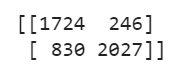

In [ ]:
plot.plot(model.history['loss'], label='training loss') #Plotting the accuracies
plot.plot(model.history['val_loss'], label='validation loss')
plot.legend()
plot.show()
# plot.savefig('LossVal_loss')
plot.plot(model.history['accuracy'], label='training accuracy')
plot.plot(model.history['val_accuracy'], label='validation accuracy')
plot.legend()
plot.show()
# plot.savefig('AccVal_acc')

### **Phase 2:** Phân loại 4 bệnh


* Bài toán multi-classification







In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
import os

from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam

Read images using `ImageDataGenerator`

In [ ]:
# Defining the parameters
IMG_CHANEL = 3
COLOR_MODE = 'rgb'
CLASS_NAME = ['TUBERCULOSIS', 'PNEUMONIA', 'MASS', 'EFFUSION']
IMAGESHAPE = [224, 224, 3]

In [ ]:
# Function to feed data set into the model
from keras.preprocessing.image import ImageDataGenerator

## For training set
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

## For validation set and testing set
testing_datagen = ImageDataGenerator(rescale =1. / 255)

In [ ]:
# Setting folder path
train_data = 'data_positive/train_positive/'
val_data = 'data_positive/val_positive/'
test_data = 'data_positive/test_positive/'

In [ ]:
train_set = train_datagen.flow_from_directory(train_data,
                                              target_size = (224, 224),
                                              batch_size = 64,
                                              shuffle = True,
                                              color_mode = "rgb",
                                              class_mode = 'categorical')

Found 10286 images belonging to 4 classes.


In [ ]:
val_set = testing_datagen.flow_from_directory(val_data,
                                              target_size = (224, 224),
                                              batch_size = 64,
                                              shuffle = True,
                                              color_mode = "rgb",
                                              class_mode = 'categorical')

Found 1145 images belonging to 4 classes.


Build model

In [ ]:
inception_v3_model = InceptionV3(input_shape=IMAGESHAPE, weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
for each_layer in inception_v3_model.layers:
		each_layer.trainable = False

In [ ]:
# Flatten output
flatten_layer = Flatten()(inception_v3_model.output)
prediction = Dense(len(CLASS_NAME), activation='softmax')(flatten_layer)

In [ ]:
final_model = Model(inputs=inception_v3_model.input, outputs=prediction)
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
# Compile model
final_model.compile(
      loss='categorical_crossentropy',
      optimizer='adam',
      metrics=['accuracy']
)

In [ ]:
# Train model
fitted_model = final_model.fit_generator(generator = train_set,
                                         validation_data = val_set,
                                         epochs=10,
                                         steps_per_epoch=len(train_set),
                                         validation_steps=len(val_set)
                                        )

<ipython-input-14-6c19f3e4afa6>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fitted_model = final_model.fit_generator(generator = train_set,


Epoch 1/10
 12/161 [=>............................] - ETA: 36:29 - loss: 9.0935 - accuracy: 0.4570

In [ ]:
# Save model
final_model.save('saved_model/inception_v3_multi_positive_size224.h5')

#### Load saved model and predict on test set

In [ ]:
test_data = 'data/test/'

from keras.preprocessing.image import ImageDataGenerator
## For validation set and testing set
testing_datagen = ImageDataGenerator(rescale =1. / 255)

In [ ]:
test_set = testing_datagen.flow_from_directory(test_data,
                                               target_size = (224, 224),
                                               batch_size = 64,
                                               shuffle = False,
                                               color_mode = "rgb",
                                               class_mode = 'categorical')

Found 4827 images belonging to 2 classes.


In [ ]:
from keras.models import load_model
# Load model
model=load_model('/content/drive/MyDrive/Paper Xu ly anh y khoa/saved_model/inception_v3_normal_positive_size224.h5')
prediction=model.predict(test_set)

76/76 [==============================] - 722s 10s/step


In [ ]:
# Convert y_pred to binary
y_pred = []
for i in range(0,len(prediction)):
    if prediction[i][0]>prediction[i][1]:
        y_pred.append(0)
    else:
        y_pred.append(1)
print(y_pred)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

In [ ]:
# Convert y_true to list
y_true = test_set.classes.tolist()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
report = classification_report(y_true, y_pred, digits=4, output_dict=True)
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.6750    0.8751    0.7622      1970
           1     0.8918    0.7095    0.7903      2857

    accuracy                         0.7771      4827
   macro avg     0.7834    0.7923    0.7762      4827
weighted avg     0.8033    0.7771    0.7788      4827



In [ ]:
# Convert the report to a DataFrame
df = pd.DataFrame(report).transpose()

# Save the DataFrame to a CSV file
df.to_csv('report_inception_normal_positive_size224.csv', index=True)

In [ ]:
print(confusion_matrix(y_true, y_pred))

[[1724  246]
 [ 830 2027]]


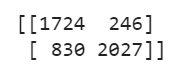

In [ ]:
plot.plot(model.history['loss'], label='training loss') #Plotting the accuracies
plot.plot(model.history['val_loss'], label='validation loss')
plot.legend()
plot.show()
# plot.savefig('LossVal_loss')
plot.plot(model.history['accuracy'], label='training accuracy')
plot.plot(model.history['val_accuracy'], label='validation accuracy')
plot.legend()
plot.show()
# plot.savefig('AccVal_acc')